### drifting the integrable Harper model, not chaotic

In [1]:
import numpy as np

import matplotlib.pyplot as plt
#from scipy.integrate import odeint
import mpmath as mpmath
import scipy
from scipy.optimize import linear_sum_assignment
from scipy.optimize import curve_fit

plt.rcParams["text.usetex"] =True  # otherwise varepsilon instead of epsilon

# %matplotlib notebook 
%matplotlib inline 

import Husimi   # Quantum routines
#import Harp     # Classical integration routines
import importlib  # for reloading routines if you need to edit them

Matplotlib is building the font cache; this may take a moment.


In [ ]:
# if higher precision with mpmath 
# https://mpmath.org/
# https://mpmath.org/doc/current/matrices.html

# less relevant I think:
# this! https://github.com/c-f-h/flamp
# https://pypi.org/project/gmpy2/

In [2]:
import mpmath  # it is already installed!

In [3]:
mpmath.libmp.BACKEND   # I installed gmpy so mpmath would be faster!

'gmpy'

In [4]:
print(mpmath.mp)

Mpmath settings:
  mp.prec = 53                [default: 53]
  mp.dps = 15                 [default: 15]
  mp.trap_complex = False     [default: False]


In [5]:
mpmath.mp.dps=51  # more decimal places, precission set here
print(mpmath.mp)

Mpmath settings:
  mp.prec = 173               [default: 53]
  mp.dps = 51                 [default: 15]
  mp.trap_complex = False     [default: False]


In [6]:
# to use mpmath I have to write a special routine to fill h0 with all numbers that are specified by mpmath

### The operator studied  is $\hat h(a,b,\epsilon) = a\cos(\hat p-b) + \epsilon \hat \phi $

In [6]:

# create a high precision version of operator h = a cos (p-b) + eps cos phi
def h0_prec(n,a,b,eps):
    # all constants converted to high precission numbers 
    fac = mpmath.fdiv(mpmath.fmul(mpmath.mpf(2),mpmath.pi),mpmath.mpf(int(n)))  # 2*pi/N
    h0 = mpmath.zeros(int(n)) # not complex yet
    cb = mpmath.cos(mpmath.mpf(b))  # cos b
    sb = mpmath.sin(mpmath.mpf(b))  # sin b
    afac = mpmath.fdiv(mpmath.mpf(a),mpmath.mpf(2))  # a/2
    acb = mpmath.fmul(afac,cb)  # a/2 cos b 
    asb = mpmath.fmul(afac,sb)  # a/2 sin b
    acbi = mpmath.fdiv(acb,mpmath.mpmathify(1j))  # a/2i cos b   
    asbi = mpmath.fdiv(asb,mpmath.mpmathify(1j))  # a/2i sin b
    
    # compute eps cos phi  on diagonal
    for j in range(int(n)):
        phij = mpmath.fmul(fac,mpmath.mpf(j)) #2 pi j/N
        h0[j,j] = mpmath.fmul(mpmath.mpf(eps),mpmath.cos(phij)) # fill diagonal with potential energy 
        # this gives eps cos phi on diagonal 
    
    # fill off diagonals with a/2 (cos p cos b + sin p sin b)
    for j in range(int(n)):
        h0[(j+1)%int(n),j] = mpmath.fsub(acb , asbi)
        h0[j,(j+1)%int(n)] = mpmath.fadd(acb , asbi) 
    return h0   # *mpmath.mpf(-1)  # is currently opposite sign to Husimi.hat_h_0_with_b

# get high precision eigenvalues and sort them in order of increasing energy 
# using precision routines!
def h0_prec_eigs(n,a,b,eps):
    h0 = h0_prec(int(n),mpmath.mpf(a),mpmath.mpf(b),mpmath.mpf(eps))   # converts constants to high precision numbers 
    #(w,vr) = mpmath.eigsy(h0) # returns real eigenvalues  if we have a symmetric real matrix
    (w,vr) = mpmath.eigh(h0) # use routine eigh if the matrix is complex hermitian 
    #iphi = np.argsort(w.tolist())  # sort needs a list or array to work, this keeps mpf numbers in array
    iphi = np.argsort(np.array(w))  # sort in order of energy
    w_arr = np.array(w)
    w_sort = w_arr[iphi]  # sorted energies, is a sorted array of mpfs 
    vr_arr = np.array(vr)  # is 1d
    vr_arr = np.reshape(vr_arr, (n,n)) # is 2d now
    vrsort = vr_arr[:,iphi] # sorted eigenvectors now 2d array of mpfs
    return w_sort,vrsort

# compute determinant of h0
def h0_prec_det(n,a,b,eps):
    h0 = h0_prec(int(n),mpmath.mpf(a),mpmath.mpf(b),mpmath.mpf(eps)) 
    deth = mpmath.det(h0)
    return deth

testit=0   # tests!
if (testit==1):
    a=1.0; eps = 0.1; b=0.1; n=4
    h0p = h0_prec(n,a,b,eps)
    h0p_old = Husimi.hat_h_0_with_b(n,a,b,eps) - np.identity(n)*a  # remove identity part
    #print(h0p)
    #print(h0p_old - np.identity(n)*a)
    j=2
    for i in range(n):
        print(h0p[j,i])
        print(h0p_old[j,i])   # has opposite sign but otherwise agrees!

# another quick test of routine 
(w,vr)= h0_prec_eigs(3,1.,mpmath.mpf(0),mpmath.mpf(0.1))   # n a b eps

In [7]:
importlib.reload(Husimi)  # if you need to reload these subroutines!

<module 'Husimi' from '/Users/aquillen/Desktop/summer24/pylab/QDrift/Husimi.py'>

In [9]:
# drift h0 slowly, nseries outputs computing instantaneous eigenvalues 
# drift rate per output is in dparms
# return sorted eigenvalues and eigenvectors, sorted in order of eigenvalue 
# uses Husimi.hat_h_0_with_b routine for computing h0
def h0_drift(n,parms0,dparms,nseries):
    w_list = np.zeros((nseries,n),dtype=float)
    vr_list = np.zeros((nseries,n,n),dtype=complex)
    for k in range(nseries):
        parms = parms0 + dparms*k  # notice drift rate 
        a = parms[0] # note the order of the parameter list, these are current parameters
        b = parms[1]
        eps = parms[2]
        #print(parms)
        if (k==0):
            print('a_init={:.6f}, b_init={:.6f}, eps_init={:.6f}'.format(a,b,eps))  # print the parameter values at the beginning 
        #mu =  parms[3]
        #mup =  parms[4]
        h0 = Husimi.hat_h_0_with_b(n,a,b,eps)  # the hamiltonian operator h_0
        (w,vr)=scipy.linalg.eigh(h0)   # find eigenvalues and eigenvectors of hermitian op
        iphi = np.argsort(np.real(w))   # sort in order of energy 
        vrsort = vr[:,iphi]   # second index gives eigenvec
        w_list[k,:] = np.real(w[iphi]) # h_0 is Hermitian so they should be real. 
        vr_list[k,:,:] = vrsort  # sorted eigenvectors 
    print('a_final={:.6f}, b_final={:.6f}, eps_final={:.6f}'.format(a,b,eps))  # print the parameter values at the end 
    return w_list,vr_list 

# a class structure to hold drifting unperturbed system
# calls above routine h0_drift
class h0_drift_class():
    def __init__(self,n,parms0,dparms,nseries):
        self.n = n
        self.nseries = nseries
        self.parms0 = parms0
        self.dparms = dparms
        self.a_0   = parms0[0] # note the order of the parameter list, these are current parameters
        self.b_0   = parms0[1]
        self.eps_0 = parms0[2]
        self.d_a   = dparms[0]
        self.d_b   = dparms[1]
        self.d_eps = dparms[2]
        self.parms_final = parms0 + (self.nseries-1)*dparms
        self.a_final   = self.parms_final[0]
        self.b_final   = self.parms_final[1]
        self.eps_final = self.parms_final[2]
        print('parms_final:', self.parms_final)

        # some vectors that display ranges 
        self.iis = np.arange(self.nseries)
        self.a_range = self.a_0 + self.d_a*self.iis 
        self.b_range = self.b_0 + self.d_b*self.iis 
        self.eps_range = self.eps_0 + self.d_eps*self.iis 
        
        # compute series of instantaneous eigenvalues and eigenvectors 
        self.w_list,self.vr_list  = h0_drift(self.n,self.parms0,self.dparms,self.nseries)  
        # note this routine uses Husimi.hat_h0_with_b
        self.de_singles = min_de_singles(self.w_list)  # compute distance to nearest eigenvalues  low precission!
        #vr_list[k,:,:] = vrsort  # eigenvectors at time k

    def compute_U(self,T,ntau):  # compute propagator across the drift 
        self.ntau = ntau
        self.T = T
        # h0_Udrift(N,T,ntau,parms0,d_parms) # compute propagator across the drift 
        self.w_s,self.vr_s,self.U_final = h0_Udrift(self.n,T,ntau,self.parms0,self.parms_final) 
        # compute propagator across the drift 

    def compute_U2(self,T,ntau):  # compute propagator across the drift using a different routine
        self.ntau = ntau
        self.T = T
        # h0_Udrift(N,T,ntau,parms0,d_parms) # compute propagator across the drift using the other routine
        self.w_s,self.vr_s,self.U_final = h0_Udrift2(self.n,T,ntau,self.parms0,self.parms_final) 
      

# returns the closest distance to next nearest energy for each eigenvalue at each time in the series
# w_list is a series of eigenvalues for the whole series
def min_de_singles(w_list):
    nseries = w_list.shape[0]
    n = w_list.shape[1]
    de_singles_list = np.zeros([nseries,n])
    for k in range(nseries):  # each in the series 
        w_vec = np.squeeze(w_list[k,:])  # list of eigenvalues 
        for j in range(n):
            w = np.copy(w_vec)
            w[j] = 1e10   # set itself to something ridiculously large
            min_de = np.min(np.abs(w - w_vec[j]))
            de_singles_list[k,j] = min_de  # each eigenvalue has a min distance to nearest 
    return de_singles_list 
        

In [10]:
# drift h0 from t=0 to t=T, by creating a propagator!
# U = e^int_0^T -ih_0(t) dt time ordered 
# N is dimension
# parms0 are [a,b,epsilon] at t=0
# parms_final are final values of the parameters 
# ntau is number of divisions in time for Trotterization
# From Husimi.py calls routines QFT 
# implements drift of hamiltonian a(1-cos(p-b)) - eps cos phi with hbar =1
def h0_Udrift(N,T,ntau,parms0,parms_final):
    #DLambda_B =np.zeros((N,N),dtype=complex)  # storing diagonal matrix for phi part

    #diagonals  used in construction 
    #Dc= np.zeros(N,dtype=complex)
    #Ds= np.zeros(N,dtype=complex)
    
    dtau = T/ntau  # step size for time 
    d_parms = (parms_final - parms0)/T # drift rate
    
    Q_FT,Q_FT_dagger = Husimi.QFT(N)  # need only be computed once, Fourier transform matrices

    #create some diagonals ahead of time, these are 1d arrays
    kvec = np.arange(N)  #integers from 0 to N-1
    pkvec = 2*np.pi*kvec/N  # frequencies or angles 
    Dc = np.cos(pkvec)
    Ds = np.sin(pkvec)
    phivec = pkvec # is the same thing really giving 2*np*j/N

    Efac = dtau  # here taking hbar = 1, equivalently T is actually a duration divided by hbar 

    # half step at the beginning 
    parms = parms0 
    a = parms[0]; b = parms[1]; epsilon= parms[2]
    D_Ah = np.diag(np.exp(-0.5j*Efac*a*(1.0 - Dc*np.cos(b) - Ds*np.sin(b)))) # exp works on each element of the array 
    # half step in Fourier basis 
    LAh  = np.matmul(Q_FT,np.matmul(D_Ah ,Q_FT_dagger))  # put into phi basis 
    U_final = LAh;

    for i in range(ntau): # each dtau
        tau = i*dtau  # time of propagator 
        parms = parms0 + d_parms*tau # parameters at each time!
        a = parms[0] # note the order of the parameter list, these are current parameters
        b = parms[1] 
        eps = parms[2]
        # full step, this is a*(1- cos (p-b)), because of -1
        D_A = np.diag(np.exp(-1j*Efac*a*(1.0 - Dc*np.cos(b) - Ds*np.sin(b)))) # create a diagonal matrix 
        LA = np.matmul(Q_FT,np.matmul(D_A ,Q_FT_dagger)) #FT into phi basis 
        # create the diagonal operator for -eps cos phi
        D_B_diag = np.exp(1j*Efac*eps*np.cos(phivec))
        # note sign of 1j (-1 * -1 = 1), 1=fullstep
        DLambda_B = np.diag(D_B_diag) # create a matrix now from the diagonal 

        U_final = np.matmul(LA,np.matmul(DLambda_B,U_final)) # mult by B and then A, full steps

    # inverse half step
    parms = parms0 + d_parms*(T - dtau)
    a = parms[0];  b = parms[1];  eps = parms[2]
    # is a half inverse step because of 0.5  
    D_Ah_inv = np.diag(np.exp(0.5j*Efac*a*(1.0-Dc*np.cos(b) - Ds*np.sin(b)))) # is a matrix
    LAh_inv     = np.matmul(Q_FT,np.matmul(D_Ah_inv ,Q_FT_dagger)) # now go back into phi basis 
    # apply inverse half step 
    U_final = np.matmul(LAh_inv,U_final)
    print('h0_Udrift: parms final: ', parms);
    
    (w,vr)=scipy.linalg.eig(U_final)  # get eigenvalues and eigenvectors, use eig (not hermitian)
    w_s,vr_s = Husimi.esort_phase(w,vr)   # sort in order of increasing eigenvalue phase
    return w_s,vr_s,U_final  # w_s are phases of the propagator, and vr_s are the eigenvalues 

# another way to do the same thing as above routine
# import scipy
# uses routine Husimi.hat_h0_with_b, 
# hbar =1 
def h0_Udrift2(N,T,ntau,parms0,parms_final):
    dtau = T/ntau  # step size for time 
    d_parms = (parms_final - parms0)/T # drift rate
    Efac = dtau  # here taking hbar = 1

    U_final= np.identity(N,dtype=complex)
    
    for i in range(ntau): # each dtau
        tau = i*dtau  # time of propagator 
        parms = parms0 + d_parms*tau # parameters at each time!
        a = parms[0] # note the order of the parameter list, these are current parameters
        b = parms[1] 
        eps = parms[2]
        #print(parms)
        h0 = Husimi.hat_h_0_with_b(N,a,b,eps)
        dU = scipy.linalg.expm(-1j*h0*Efac)   #e^{-(i/hbar) H dt}
        U_final = np.matmul(dU,np.copy(U_final))

    (w,vr)=scipy.linalg.eig(U_final)  # get eigenvalues and eigenvectors, U is not hermitian so use eig
    w_s,vr_s = Husimi.esort_phase(w,vr)   # sort in order of increasing eigenvalue phase
    return w_s,vr_s,U_final  # w_s are phases of the propagator, and vr_s are the eigenvalues 
        


### Compute transition matrices using a propagator (evolution!)

In [11]:
# take the propagator and compute transition matrices of 
#   amplitudes and phases  of <v_i|U_trans|u_j>   
#   |v_i> , eigenvecs of h0 at first time 
#   |u_j>,  eigenvecs of h0 at final time
#    U_trans is the propagator 
# arguments:  
#    drift class hclass  
def comp_trans_h0(hclass):
    #vr_first = np.squeeze(hclass.vr_list[0,:,:])  # eigenvecs of h0 at first time
    #vr_last  = np.squeeze(hclass.vr_list[hclass.nseries-1,:,:])   # eigenvecs of h0 at last time
    #U_trans = hclass.U_final   # propagator 
    
    #n = vr_first.shape[0]
    n = hclass.vr_list.shape[1]
    t_matrix = np.zeros((n,n))  # for storing amplitudes 
    p_matrix = np.zeros((n,n))  # for storing phases 
    for i in range(n):
        #v = np.squeeze(vr_first[:,i]) # i-th eigenvector of first set
        v = np.squeeze(hclass.vr_list[0,:,i]) # i-th eigenvector of first set, eigenvectors initially 
        for j in range(n):
            #u = np.squeeze(vr_last[:,j])  # j-th eigenvector of last set
            u = np.squeeze(hclass.vr_list[hclass.nseries-1,:,j])  # j-th eigenvector of last set, eigenvalues at the end
            uUv = np.vdot(u,np.matmul(hclass.U_final,v))   # compute <u|U_trans|v>  , this is <final_j|U_T|init_i>
            t_matrix[i,j] = np.abs(uUv) # compute magnitude and put it in a matrix  i is for initial, j for final
            p_matrix[i,j] = np.angle(uUv) # compute phase and put it in a matrix 
    return t_matrix,p_matrix 

# same as above routine except using matrices of eigenvecs directly 
def comp_trans_uUv(vr2,U,vr1):
    n = vr1.shape[0]
    t_matrix = np.zeros((n,n))  # for storing amplitudes 
    p_matrix = np.zeros((n,n))  # for storing phases 
    for i in range(n):
        v = np.squeeze(vr1[:,i]) # i-th eigenvector of first set
        for j in range(n):
            u = np.squeeze(vr2[:,j])  # j-th eigenvector of last set
            uUv = np.vdot(u,np.matmul(U,v))   # compute <u|U_trans|v>
            t_matrix[i,j] = np.abs(uUv) # compute magnitude and put it in a matrix 
            p_matrix[i,j] = np.angle(uUv) # compute phase and put it in a matrix 
            #<final_j|U_T|init_i>, indexing: t_matrix[i,j]
    return t_matrix,p_matrix 

# plots two matrices one next to another, both need to be real 
# with colorbars on both sides , not currently used here
def plt2_trans(t_matrix,p_matrix,label1,label2,ofile):
    fig,axarr = plt.subplots(1,2,figsize=(5.0,2),sharex=True,sharey=True,dpi=300)
    plt.subplots_adjust(hspace=0,wspace=0,top=0.96,right=0.86,left=0.16,bottom=0.0)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[1].set_xticks([])
    axarr[1].set_yticks([])
    im0 = axarr[0].imshow(t_matrix,origin='lower',cmap='viridis')
    im1 = axarr[1].imshow(p_matrix,origin='lower',cmap='twilight')  # cyclic colormap
    cax0=fig.add_axes([0.13,0.13,0.019,0.65])
    cax1=fig.add_axes([0.87,0.13,0.019,0.65])
    cbar0 = plt.colorbar(im0,cax=cax0,location='left',label='amplitude')  
    cbar1 = plt.colorbar(im1,cax=cax1) 
    cbar1.set_label('phase',labelpad=-1)
    cbar1.set_ticks(ticks=[-np.pi, 0, np.pi], labels=[r'-$\pi$', '0', r'$\pi$'])
    axarr[0].text(0.0,1.02, label1, transform = axarr[0].transAxes)
    axarr[0].text(0.02,0.9, label2, transform = axarr[0].transAxes,color='lightgreen')
    
    if (len(ofile)>3):
        plt.savefig(ofile)
    plt.show()

#l1 = r"a=1,$\epsilon$=0.5,b = 0 to 1'; l2 = 'T=2"
#plt2_trans(t_matrix,p_matrix,l1,l2,'junk.png')  # for checking routine

# all checks with no drift passed, perpendicularity passed, dot -> vdot was the problem 
# and order of <u U v> was corrected in comp_trans


In [12]:
# make a figure of transition matrices, for the case of constant epsilon, a
# dclass is a drift class
# tmatrix_series is an array of transition matrices
# Tarr is the list of durations for drift
def Tarr_fig(dclass,tmatrix_series,Tarr,ofile):
    nser = len(Tarr)
    fig,axarr = plt.subplots(1,nser,figsize=(6.0,1.6),sharex=True,sharey=True,dpi=300)
    plt.subplots_adjust(hspace=0,wspace=0,top=0.96,right=0.99,left=0.12,bottom=0.0)
    zmax = np.max(np.squeeze(tmatrix_series[0,:,:]))  # so that all images on the same scale 
    nn_b = dclass.d_b * dclass.nseries*dclass.n/np.pi + 1e-5
    Delta_b = dclass.b_final - dclass.b_0
    om2 = dclass.eps_0*dclass.a_0
    eps_mid = dclass.eps_0 + dclass.eps_final*0.5
    for i in range(nser):
        Th = Tarr[i];  # duration in units of hbar
        label2 = r'$T/\hbar$={:.0f}'.format(Th)  # duration label T/hbar
        axarr[i].set_xticks([])
        axarr[i].set_yticks([])
        t_matrix = np.copy(np.squeeze(tmatrix_series[i,:,:]))  # transition matrix 
        #t_matrix[3,20] = 1 so we could see that x axis is final, y axis is initial
        if (i==0):
            im0 = axarr[i].imshow(t_matrix,origin='lower',cmap='viridis',vmin=0,vmax=zmax)
        else:
            im  = axarr[i].imshow(t_matrix,origin='lower',cmap='viridis',vmin=0,vmax=zmax)
        axarr[i].text(0.02,0.92, label2, transform = axarr[i].transAxes,color='lightgreen',fontsize=8)
        
        #beta_ad2 = (10.0/nn_b) * (0.5/om2) * (10/Tarr[i])  # these two expressions agree!
        beta_ad = Delta_b/(Th*2*np.pi/dclass.n) *1/om2   # 2pi/n is hbar
        #print(beta_ad,beta_ad2)

        gamma_Q_ad = (Delta_b/Th)* (dclass.n**2/(4*np.pi**3*eps_mid))
        print('gamma_Q_add = {:.1e}'.format(gamma_Q_ad)  ) 
        if (gamma_Q_ad > 0.01):
            gamma_lab = r'$\gamma_{\mathrm Q, \mathrm a \mathrm d}$=' + '{:.2f}'.format(gamma_Q_ad)  # adiabatic limit
        else:
            gamma_lab = r'$\gamma_{\mathrm Q, \mathrm a \mathrm d}$=' + '{:.1e}'.format(gamma_Q_ad) 
        
        
        if (beta_ad > 0.01):
            beta_lab = r'$\beta_{\mathrm a \mathrm d}$=' + '{:.2f}'.format(beta_ad)
        else:
            beta_lab = r'$\beta_{\mathrm a \mathrm d}$=' + '{:.1e}'.format(beta_ad)
        axarr[i].text(0.02,0.83, beta_lab, transform = axarr[i].transAxes,color='lightgreen',fontsize=8)
        axarr[i].text(0.97,0.025, gamma_lab, transform = axarr[i].transAxes,color='lightgreen',fontsize=8,ha='right')
        #print(beta_lab)

    l1 = r'$N$={:d},$a$={:.0f},$\epsilon$={:.1f},'.format(dclass.n,dclass.a_0,dclass.eps_0)
    lb = r'$b$={:.0f}'.format(dclass.b_0) + '\u2192' + r'{:d}$\pi/N$'.format(int(nn_b))
    l1 = l1+lb  # informative labels 

    # colorbar 
    cax0=fig.add_axes([0.085,0.16,0.012,0.64])
    cbar0 = plt.colorbar(im0,cax=cax0,location='left',label='amplitude',format="%4.1f",ticks=[0.0,0.3,0.6])  
    axarr[0].text(0.0,1.03, l1, transform = axarr[0].transAxes)
    axarr[0].text(-34,50,'a)',fontsize=14)

    # plot separatrices as horizontal and vertical lines 
    bottom,top = sep_energy(dclass)  # These are energies of the separatrix 
    ibottom = np.argmin(np.abs(dclass.w_list[0,:] - bottom[0]))  # indexes of sep initially
    itop = np.argmin(np.abs(dclass.w_list[0,:] - top[0])) 
    n = dclass.n
    sepcolor = 'mediumpurple'; lwsep=0.4
    for i in range(nser):
        axarr[i].plot([itop,itop],[0,n-1],'-',color=sepcolor,lw=lwsep)
        axarr[i].plot([0,n-1],[itop,itop],'-',color=sepcolor,lw=lwsep)
        axarr[i].plot([ibottom,ibottom],[0,n-1],'-',color=sepcolor,lw=lwsep)
        axarr[i].plot([0,n-1],[ibottom,ibottom],'-',color=sepcolor,lw=lwsep)
    axarr[0].set_xlabel('index j',labelpad = 1)
    axarr[0].set_ylabel('index i',labelpad = 0.1)

    if (len(ofile)>3):
        plt.savefig(ofile)
    plt.show()


In [13]:
# compute transition matrices for a series of different drift durations
# drift over durations in Tarr to dclass.parms_final
def T_matrix_ser(dclass,Tarr,ntau_arr):
    nser = len(Tarr)
    n = dclass.n
    tmatrix_series = np.zeros((nser,n,n))
    for i in range(nser):
        T = Tarr[i] 
        ntau = int(ntau_arr[i])
        print(T,ntau)
        dclass.compute_U2(T,ntau)  #  drift over duration T/hbar to self.parms_final 
        t_matrix,p_matrix = comp_trans_h0(dclass) # t is amplitude p is phase
        tmatrix_series[i,:,:] = t_matrix  
    return tmatrix_series

# compute separatix energy as a function of time 
# consistent with h0 defined in Husimi.py which is a(1-cos p-b) - eps cos phi
def sep_energy(h0class):
    #a_vec = h0class.parms0[0] + h0class.dparms[0] * h0class.iis
    #eps_vec = h0class.parms0[2] + h0class.dparms[2] * h0class.iis
    top = 2*h0class.a_range - h0class.eps_range
    bottom = h0class.eps_range 
    return bottom,top  # separatrix energies as a function of time
    # subtract a if you want to remove the contant term and are using the old version of hat h


In [14]:
# find minimum denergy dif in the entire series 
def de_min_arr(dclass):
    de_min = np.zeros(dclass.n)
    for i in range(dclass.n):  # for each energy level in order 
        de_min[i] = np.min(dclass.de_singles[:,i] )
    return de_min

# compute mininum distances using drift class using precision versions 
def high_res_de(dclass):  # uses initial conditions from the drift class 
    (w,vr) = h0_prec_eigs(dclass.n,dclass.a_0,0,dclass.eps_0) # try the precision version!
    de_vec = min_de_vec(w)  # precision version
    (w,vr) = h0_prec_eigs(dclass.n,dclass.a_0,np.pi/dclass.n,dclass.eps_0) # try the precision version!
    de_vec2 = min_de_vec(w)  # precision version
    return de_vec,de_vec2

# make a plot showing Landau zener estimated critical energy levels for drift durations given in Tarr array 
def plt_de_bdrift(dclass,Tarr,ofile):
    bottom,top = sep_energy(dclass)  # These are energies of the separatrix 
    ibottom = np.argmin(np.abs(dclass.w_list[0,:] - bottom[0]))
    itop = np.argmin(np.abs(dclass.w_list[0,:] - top[0]))
    #print(ibottom,itop)
    de_min = de_min_arr(dclass) # min distance between eigenvalues whole series 
    
    fig,ax = plt.subplots(1,1,figsize=(2.5,2.5),dpi=400)
    plt.subplots_adjust(left=0.19,right=0.98,top=0.98,bottom=0.19)
    ax.plot(np.log10(de_min),'k-',lw=2)
    if (1==0):  # high precission stuff I checked and it is consistent but kind of ugly and not smooth
        de_min_prec1,de_min_prec2 = high_res_de(dclass)
        ax.plot(np.log10(de_min_prec1),'g-',lw=1)
        ax.plot(np.log10(de_min_prec2),'g-',lw=1)
    ax.set_xlabel(r'index $j$',labelpad=2)
    ax.set_ylabel(r'$\log_{10} dE_j$',labelpad=2)
    
    # draw seps
    ymin,ymax = ax.get_ylim()
    sepcolor = 'mediumpurple'
    ax.plot([itop,itop],[ymin,ymax],':', alpha=0.9,lw=3,color=sepcolor)
    ax.plot([ibottom,ibottom],[ymin,ymax],':', alpha=0.9,lw=3,color=sepcolor)
    nn_b = dclass.d_b * dclass.nseries*dclass.n/np.pi + 1e-5  # for display
    
    # horizontal lines showing Landau Zener guesses
    xmin,xmax = ax.get_xlim()
    Delta_b = np.abs(dclass.b_final - dclass.b_0) # total distance in b drifted 
    for i in range(len(Tarr)):
        de_min =2*np.sqrt(   Delta_b/(np.pi**2*Tarr[i]) * np.log(2.0) * (dclass.a_0 + dclass.eps_0) )
        #de_min =np.sqrt( (4/dclass.n) * Delta_b/(np.pi**2*Tarr[i]) * np.log(2.0)) 
        lde_min = np.log10(de_min)
        ax.plot([xmin,xmax],[lde_min,lde_min],'--',lw=1,alpha=0.7,color='dodgerblue')
        Tlab = '{:.0f}'.format(Tarr[i])
        ax.text(42,lde_min,Tlab,ha='center',va='baseline',fontsize=8,color='dodgerblue')
        beta_ad = (10.0/nn_b) * (0.5/(dclass.eps_0*dclass.a_0)) * (10/Tarr[i])
        if (beta_ad > 0.01):
            beta_lab = r'$\beta_{\mathrm a \mathrm d}$=' + '{:.2f}'.format(beta_ad)
        else:
            beta_lab = r'$\beta_{\mathrm a \mathrm d}$=' + '{:.1e}'.format(beta_ad)
        #print(beta_lab)

    ax.text(-19, -1,'b)',fontsize=20)
    #imean = len(de_min)/2
    ax.text(23.5,-4,'circulation',rotation=90,ha='center',va='center')
    ax.text(6 ,-5.5,'libration',rotation=90,ha='center',va='center')
    ax.text(44,-5.5,'libration',rotation=90,ha='center',va='center')
    
    if (len(ofile)>3):
        plt.savefig(ofile)
    plt.show()


In [15]:
# make a figure showing a series of transition matrices 
n=49; a=1.0; eps=0.500; b=0; parms0 = np.array([a,b,eps])
nseries=100  # not being used in actual routines except to set actual range of drift 
d_a = 0.0; 
Delta_b = 10*np.pi/n   # d_b = Delta_b/nseries = 10 * np.pi/n /100 = np.pi/n /10 
#d_b = (2*np.pi/n)/20 ;   # only varying b 
d_b = Delta_b/nseries # equivalent 
d_eps = 0.0; 
dparms = np.array([d_a,d_b,d_eps])
yy_driftb   = h0_drift_class(n,parms0,dparms,nseries)
#print('b final {:.2f}'.format(d_b*nseries)) # agrees

Tarrb = np.array([20,100,500,5000,50000])  # these are T/hbar values 
ntau_arrb =np.array([100,200,1000,10000,100000])  #

# compute a series of transition matrices with different drift durations, but same final parameters 
tmatrix_series_y = T_matrix_ser(yy_driftb,Tarrb,ntau_arrb)  # this takes a while!
# drift over durations in Tarrb to yy_driftb.parms_final
#Tarr_fig(yy_driftb,tmatrix_series_b,Tarrb,'yy_driftb_b.png') # show them 

parms_final: [1.         0.63472994 0.5       ]
a_init=1.000000, b_init=0.000000, eps_init=0.500000
a_final=1.000000, b_final=0.634730, eps_final=0.500000
20 100
100 200
500 1000
5000 10000
50000 100000


gamma_Q_add = 8.2e-01
gamma_Q_add = 1.6e-01
gamma_Q_add = 3.3e-02
gamma_Q_add = 3.3e-03
gamma_Q_add = 3.3e-04


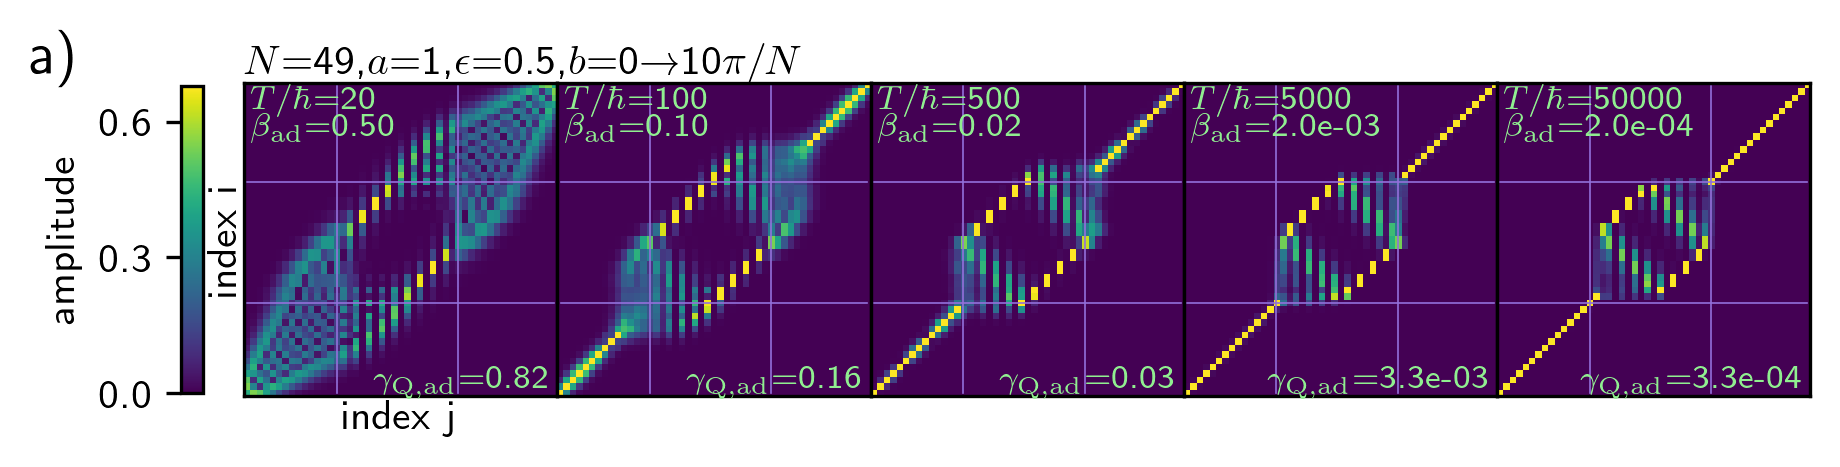

In [16]:
Tarr_fig(yy_driftb,tmatrix_series_y,Tarrb,'yy_driftb_b.png') # show them 

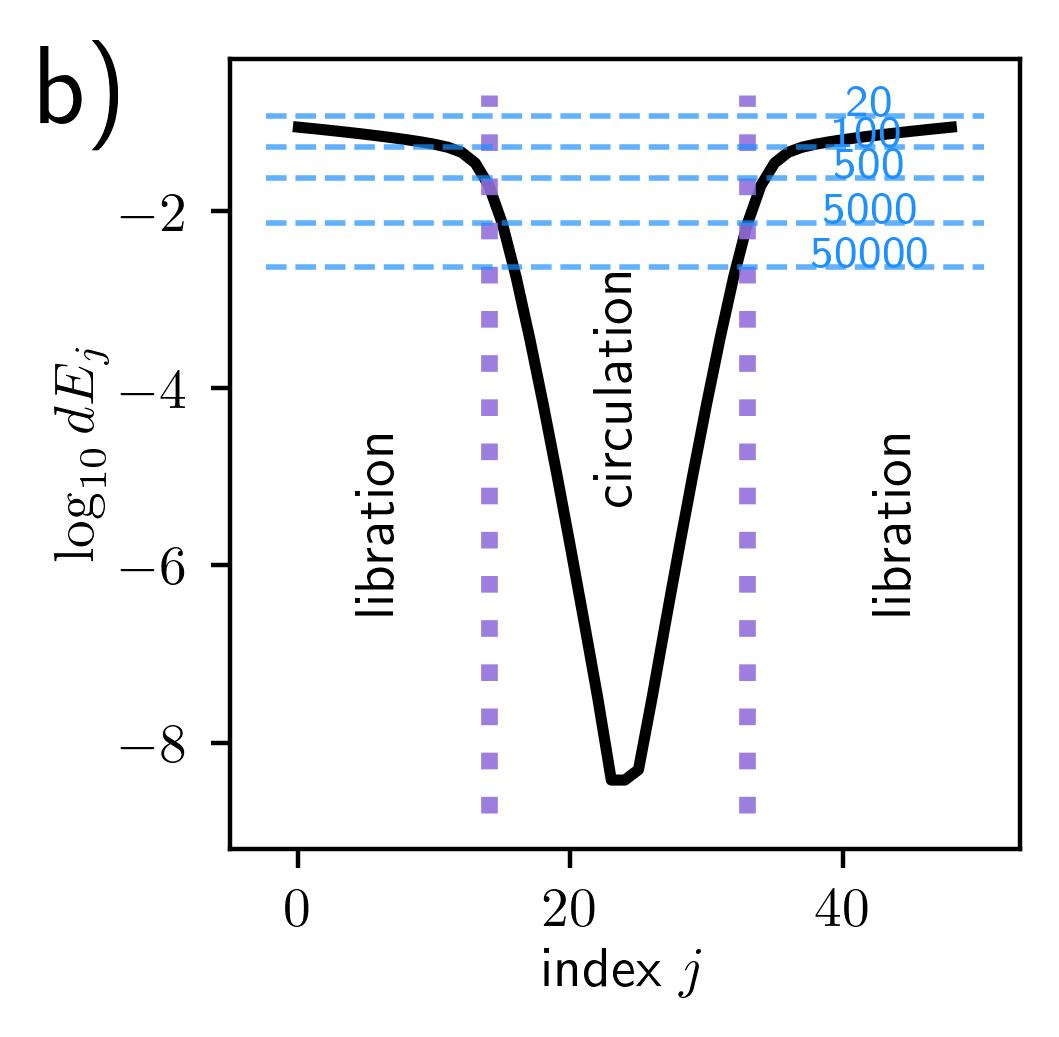

In [319]:
# make accompanying plots showing drift rates estimated via Landau Zener
#plt_de_bdrift(yy_driftb,Tarr,'minde.png')
plt_de_bdrift(yy_driftb,Tarrb,'minde_b.png')

### drifting both epsilon and b

In [307]:
# make a figure of transition matrices, for the case of varying epsilon, b
# dclass is a drift class
# tmatrix_series is an array of transition matrices
# Tarr is the list of durations for drift
def Tarr_fig_evar(dclass,tmatrix_series,Tarr,ablabel,ofile):
    nser = len(Tarr)
    fig,axarr = plt.subplots(1,nser,figsize=(6.0,1.6),sharex=True,sharey=True,dpi=300)
    plt.subplots_adjust(hspace=0,wspace=0,top=0.95,right=0.99,left=0.12,bottom=0.04)
    zmax = np.max(np.squeeze(tmatrix_series[0,:,:]))
    eps_mid = (dclass.eps_0 + dclass.eps_final)/2
    #nn_b = dclass.d_b * dclass.nseries*dclass.n/np.pi + 1e-5
    om2 = eps_mid*dclass.a_0
    Delta_b = np.abs(dclass.b_final - dclass.b_0)
    for i in range(nser):
        Th = Tarr[i];   # is actually T/hbar
        label2 = r'$T/\hbar$={:.0f}'.format(Th)
        bdot = Delta_b/(Th*2*np.pi/dclass.n)
        beta_ad = bdot/om2
        print('beta_ad = {:.2e}, bdot = {:.2e}'.format(beta_ad,bdot))
    
        #beta_ad2 = (10.0/nn_b) * (0.5/om2) * (10/Tarr[i])   # not sure if I like this!!!!!!
        if (beta_ad > 0.01):
            beta_lab = r'$\beta_{\mathrm a \mathrm d}$=' + '{:.2f}'.format(beta_ad)  # adiabatic limit
        else:
            beta_lab = r'$\beta_{\mathrm a \mathrm d}$=' + '{:.1e}'.format(beta_ad)
        #print(beta_lab)
        #print(beta_ad,beta_ad2)

        gamma_Q_ad = (Delta_b/Th)* (dclass.n**2/(4*np.pi**3*eps_mid))
        print('gamma_Q_add = {:.1e}'.format(gamma_Q_ad)  ) 
        if (gamma_Q_ad > 0.01):
            gamma_lab = r'$\gamma_{\mathrm Q, \mathrm a \mathrm d}$=' + '{:.2f}'.format(gamma_Q_ad)  # adiabatic limit
        else:
            gamma_lab = r'$\gamma_{\mathrm Q, \mathrm a \mathrm d}$=' + '{:.1e}'.format(gamma_Q_ad) 
    
        axarr[i].set_xticks([])
        axarr[i].set_yticks([])
        t_matrix = np.squeeze(tmatrix_series[i,:,:])
        if (i==0):
            im0 = axarr[i].imshow(t_matrix,origin='lower',cmap='viridis',vmin=0,vmax=zmax) # for colorbar 
        else:
            im  = axarr[i].imshow(t_matrix,origin='lower',cmap='viridis',vmin=0,vmax=zmax)
        axarr[i].text(0.02,0.92, label2, transform = axarr[i].transAxes,color='lightgreen',fontsize=8)
        axarr[i].text(0.02,0.84, beta_lab, transform = axarr[i].transAxes,color='lightgreen',fontsize=8)
        axarr[i].text(0.97,0.025, gamma_lab, transform = axarr[i].transAxes,color='lightgreen',fontsize=8,ha='right')

    l1 = r'$N$={:d},$a$={:.0f},'.format(dclass.n,dclass.a_0)     # u2192 is right arrow
    l2 = r'$\epsilon$={:.1f}'.format(dclass.eps_0) + '\u2192' + '{:.1f},'.format(dclass.eps_final)   
    #lb = r'$b$={:.0f}'.format(dclass.b_0) + '\u2192' + r'{:d}$\pi/N$'.format(int(nn_b))
    lb = r'$b$={:.0f}'.format(dclass.b_0) + '\u2192' + r'{:.1f}'.format(dclass.b_final)

    # compute probability of capture
    Delta_eps = np.abs(dclass.eps_0 - dclass.eps_final)
    Delta_b = np.abs(dclass.b_0 - dclass.b_final)
    eps_mid = np.abs(dclass.eps_0 + dclass.eps_final)/2
    P_c = (Delta_eps/Delta_b) * 4/(np.pi*np.sqrt(eps_mid))  # independent of drift rate 
    pclabel = r', Capture probability={:.2f}'.format(P_c)
    
    l1 = l1+l2+lb+pclabel

    # colorbar
    cax0=fig.add_axes([0.085,0.16,0.012,0.64])
    cbar0 = plt.colorbar(im0,cax=cax0,location='left',label='amplitude',format="%4.1f",ticks=[0.0,0.3,0.6])  
    
    axarr[0].text(0.0,1.03, l1, transform = axarr[0].transAxes) # top label
    
    axarr[0].text(-0.5,0.96,ablabel,fontsize=14,transform = axarr[0].transAxes)  # ab label

    # plot separatrices as horizontal and vertical lines at beginning 
    bottom,top = sep_energy(dclass)  # These are energies of the separatrix at different times 
    ibottom = np.argmin(np.abs(dclass.w_list[0,:] - bottom[0]))  # indexes of sep initially
    itop = np.argmin(np.abs(dclass.w_list[0,:] - top[0])) 
    n = dclass.n
    sepcolor = 'mediumpurple'; lwsep=0.6
    for i in range(nser):
        #axarr[i].plot([itop,itop],[0,n-1],':',color=sepcolor,lw=lwsep)
        axarr[i].plot([0,n-1],[itop,itop],':',color=sepcolor,lw=lwsep) # horizontal 
        #axarr[i].plot([ibottom,ibottom],[0,n-1],':',color=sepcolor,lw=lwsep)
        axarr[i].plot([0,n-1],[ibottom,ibottom],':',color=sepcolor,lw=lwsep)

    # plot separatrices as horizontal and vertical lines at end 
    ibottom = np.argmin(np.abs(dclass.w_list[0,:] - bottom[-1]))  # indexes of sep at the end 
    itop = np.argmin(np.abs(dclass.w_list[0,:] - top[-1])) 
    sepcolor = 'red'; lwsep=0.4
    for i in range(nser):
        axarr[i].plot([itop,itop],[0,n-1],'-',color=sepcolor,lw=lwsep)  # vertical 
        #axarr[i].plot([0,n-1],[itop,itop],'-',color=sepcolor,lw=lwsep)
        axarr[i].plot([ibottom,ibottom],[0,n-1],'-',color=sepcolor,lw=lwsep)
        #axarr[i].plot([0,n-1],[ibottom,ibottom],'-',color=sepcolor,lw=lwsep)

    axarr[0].set_xlabel('index j',labelpad = 1)
    axarr[0].set_ylabel('index i',labelpad = 0.1)

    if (len(ofile)>3):
        plt.savefig(ofile)
    plt.show()


In [237]:
# make a figure showing a series of transition matrices for b, eps both drifting 
#this is low prob capture a)
n=49; a=1.0; eps=0.300; b=0; parms0 = np.array([a,b,eps])
Delta_b = 1.1   # 30*np.pi/n   # d_b = Delta_b/nseries = 10 * np.pi/n /100 = np.pi/n /10 
Delta_eps = 0.1
nseries=100  # only important for making final values consistent with Delta_b, Delta_eps
d_a = 0.0; 
d_b = Delta_b/nseries  # varying b by a total of Delta_b
d_eps = Delta_eps/nseries;   # varying epsilon by a total of Delta_eps
dparms = np.array([d_a,d_b,d_eps])
zz_drift_a   = h0_drift_class(n,parms0,dparms,nseries)
#print('b final {:.2f}'.format(d_b*nseries))
#print('eps final {:.2f}'.format(d_eps*nseries + eps))

Tarr_a = np.array([10,100,500,5000])
ntau_arr_a =np.array([100,200,1000,10000])  # number of Trotterization steps
eps_mid = (2*eps + Delta_eps)/2
P_c = (Delta_eps/Delta_b) * 4/(np.pi*np.sqrt(eps_mid))   # based on pendulum using eps in the middle
print('prob capture: ',P_c)

# compute a series of transition matrices with different drift rates
tmatrix_series_a = T_matrix_ser(zz_drift_a,Tarr_a,ntau_arr_a)  # this takes a while!


parms_final: [1.    1.089 0.399]
a_init=1.000000, b_init=0.000000, eps_init=0.300000
a_final=1.000000, b_final=1.089000, eps_final=0.399000
prob capture:  0.1956516033675495
10 100
100 200
500 1000
5000 10000


In [357]:
# make a figure showing a series of transition matrices for b, eps both drifting 
# this is high prob of capture b)
n=49; a=1.0; eps=0.100; b=0; parms0 = np.array([a,b,eps])
nseries=100
d_a = 0.0; 
Delta_b = 1.0  # 20*np.pi/n   # d_b = Delta_b/nseries = 10 * np.pi/n /100 = np.pi/n /10 
d_b = Delta_b/nseries  # varying b by a total of Delta_b
Delta_eps = 0.50
d_eps = Delta_eps/nseries;   # varying epsilon by a total of Delta_eps
dparms = np.array([d_a,d_b,d_eps])
zz_drift_b   = h0_drift_class(n,parms0,dparms,nseries)
print('b final {:.2f}'.format(d_b*nseries))
print('eps final {:.2f}'.format(d_eps*nseries + eps))

Tarr_b = np.array([15,100,500,5000])
ntau_arr_b =np.array([100,200,1000,10000])

eps_mid = (2*eps + Delta_eps)/2
P_c = (Delta_eps/Delta_b) * 4/(np.pi*np.sqrt(eps_mid))   # based on pendulum using eps in the middle
print('prob capture: ',P_c)

tmatrix_series_b = T_matrix_ser(zz_drift_b,Tarr_b,ntau_arr_b)  # this takes a while!

parms_final: [1.    0.99  0.595]
a_init=1.000000, b_init=0.000000, eps_init=0.100000
a_final=1.000000, b_final=0.990000, eps_final=0.595000
b final 1.00
eps final 0.60
prob capture:  1.0760838185215222
15 100
100 200
500 1000
5000 10000


beta_ad = 2.43e+00, bdot = 8.49e-01
gamma_Q_add = 6.0e+00
beta_ad = 2.43e-01, bdot = 8.49e-02
gamma_Q_add = 6.0e-01
beta_ad = 4.86e-02, bdot = 1.70e-02
gamma_Q_add = 1.2e-01
beta_ad = 4.86e-03, bdot = 1.70e-03
gamma_Q_add = 1.2e-02


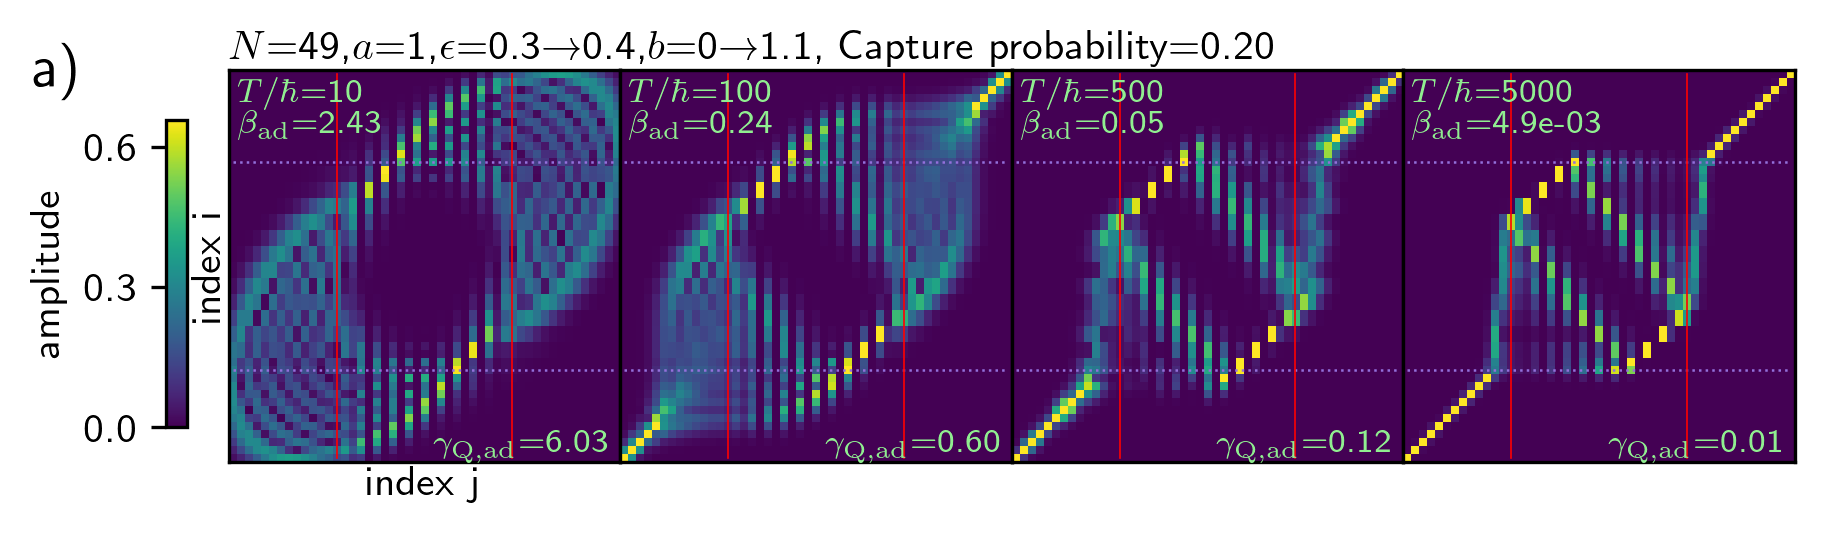

beta_ad = 1.48e+00, bdot = 5.15e-01
gamma_Q_add = 3.7e+00
beta_ad = 2.22e-01, bdot = 7.72e-02
gamma_Q_add = 5.5e-01
beta_ad = 4.44e-02, bdot = 1.54e-02
gamma_Q_add = 1.1e-01
beta_ad = 4.44e-03, bdot = 1.54e-03
gamma_Q_add = 1.1e-02


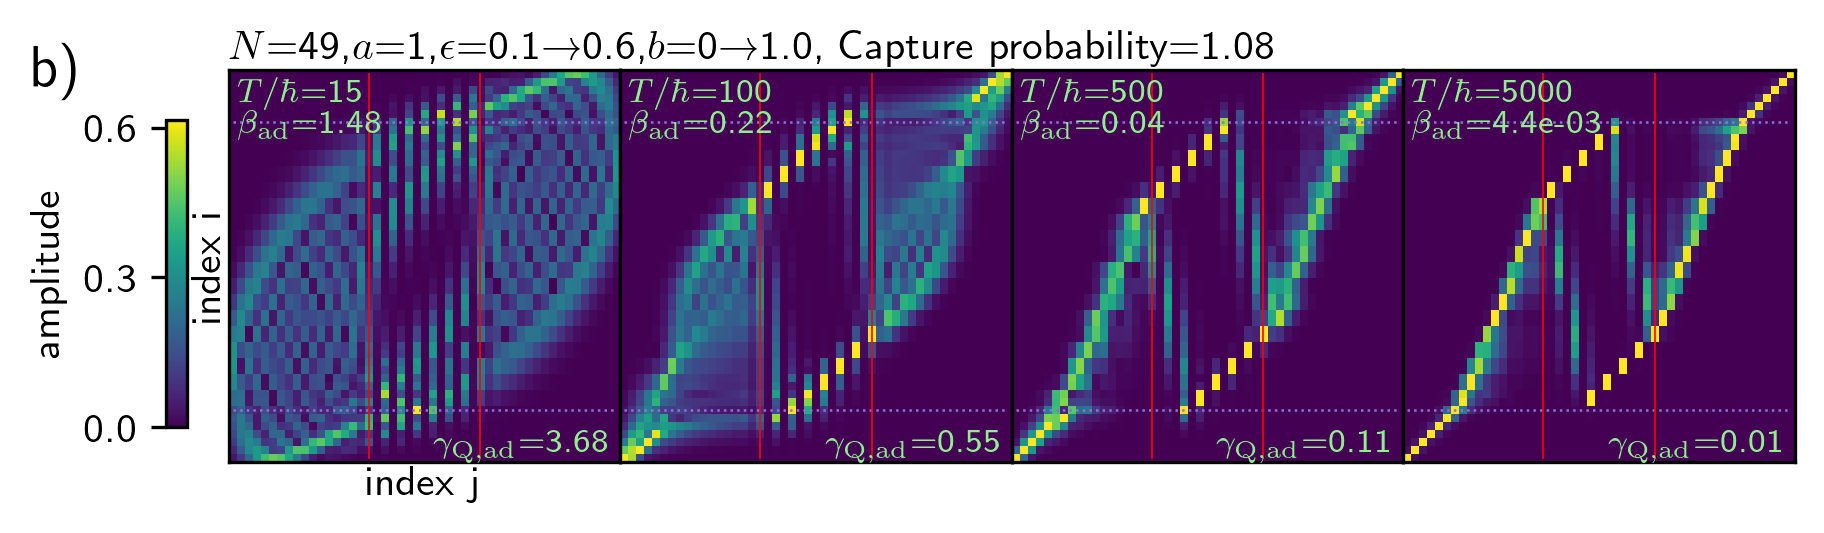

In [358]:
# now make two figures 
Tarr_fig_evar(zz_drift_a,tmatrix_series_a,Tarr_a,'a)','zz_drift_a.png') # show them 
# compute a series of transition matrices with different drift rates

Tarr_fig_evar(zz_drift_b,tmatrix_series_b,Tarr_b,'b)','zz_drift_b.png') # show them 

In [359]:

# this is high prob, smaller N
n=32; a=1.0; eps=0.100; b=0; parms0 = np.array([a,b,eps])
nseries=100
d_a = 0.0; 
Delta_b = 1.0 # 20*np.pi/n   # d_b = Delta_b/nseries = 10 * np.pi/n /100 = np.pi/n /10 
d_b = Delta_b/nseries  # varying b by a total of Delta_b
Delta_eps = 0.5
d_eps = Delta_eps/nseries;   # varying epsilon by a total of Delta_eps
dparms = np.array([d_a,d_b,d_eps])
zz_drift_c   = h0_drift_class(n,parms0,dparms,nseries)
#print('b final {:.2f}'.format(d_b*nseries))
#print('eps final {:.2f}'.format(d_eps*nseries + eps))

Tarr_c = Tarr_b * (n/49)  # correct so have same T not same T/hbar 
ntau_arr_c =np.array([100,200,1000,10000])

eps_mid = (2*eps + Delta_eps)/2
P_c = (Delta_eps/Delta_b) * 4/(np.pi*np.sqrt(eps_mid))   # based on pendulum using eps in the middle
print('prob capture: ',P_c)

tmatrix_series_c = T_matrix_ser(zz_drift_c,Tarr_c,ntau_arr_c)  # this takes a while!

parms_final: [1.    0.99  0.595]
a_init=1.000000, b_init=0.000000, eps_init=0.100000
a_final=1.000000, b_final=0.990000, eps_final=0.595000
prob capture:  1.0760838185215222
9.795918367346937 100
65.3061224489796 200
326.53061224489795 1000
3265.3061224489793 10000


In [360]:
 
# this is high cap prob, larger N
n=61; a=1.0; eps=0.100; b=0; parms0 = np.array([a,b,eps])
nseries=100
d_a = 0.0; 
Delta_b = 1.0   # d_b = Delta_b/nseries = 10 * np.pi/n /100 = np.pi/n /10 
d_b = Delta_b/nseries  # varying b by a total of Delta_b
Delta_eps = 0.5
d_eps = Delta_eps/nseries;   # varying epsilon by a total of Delta_eps
dparms = np.array([d_a,d_b,d_eps])
zz_drift_d   = h0_drift_class(n,parms0,dparms,nseries)
#print('b final {:.2f}'.format(d_b*nseries))
#print('eps final {:.2f}'.format(d_eps*nseries + eps))

Tarr_d = Tarr_b* (n/49)  # correct so have same T not same T/hbar
ntau_arr_d =np.array([100,200,1000,10000])

eps_mid = (2*eps + Delta_eps)/2
P_c = (Delta_eps/Delta_b) * 4/(np.pi*np.sqrt(eps_mid))   # based on pendulum using eps in the middle
print('prob capture: ',P_c)

tmatrix_series_d = T_matrix_ser(zz_drift_d,Tarr_d,ntau_arr_d)  # this takes a while!

parms_final: [1.    0.99  0.595]
a_init=1.000000, b_init=0.000000, eps_init=0.100000
a_final=1.000000, b_final=0.990000, eps_final=0.595000
prob capture:  1.0760838185215222
18.6734693877551 100
124.48979591836735 200
622.4489795918367 1000
6224.489795918367 10000


In [363]:
# this is high cap prob, larger N
n=90; a=1.0; eps=0.100; b=0; parms0 = np.array([a,b,eps])
nseries=100
d_a = 0.0; 
Delta_b = 1.0   # d_b = Delta_b/nseries = 10 * np.pi/n /100 = np.pi/n /10 
d_b = Delta_b/nseries  # varying b by a total of Delta_b
Delta_eps = 0.5
d_eps = Delta_eps/nseries;   # varying epsilon by a total of Delta_eps
dparms = np.array([d_a,d_b,d_eps])
zz_drift_e   = h0_drift_class(n,parms0,dparms,nseries)
#print('b final {:.2f}'.format(d_b*nseries))
#print('eps final {:.2f}'.format(d_eps*nseries + eps))

Tarr_e = Tarr_b* (n/49)  # correct so have same T not same T/hbar
ntau_arr_e =np.array([130,250,1500,15000])

eps_mid = (2*eps + Delta_eps)/2
P_c = (Delta_eps/Delta_b) * 4/(np.pi*np.sqrt(eps_mid))   # based on pendulum using eps in the middle
print('prob capture: ',P_c)

tmatrix_series_e = T_matrix_ser(zz_drift_e,Tarr_e,ntau_arr_e)  # this takes a while!

parms_final: [1.    0.99  0.595]
a_init=1.000000, b_init=0.000000, eps_init=0.100000
a_final=1.000000, b_final=0.990000, eps_final=0.595000
prob capture:  1.0760838185215222
27.551020408163264 130
183.67346938775512 250
918.3673469387755 1500
9183.673469387755 15000


beta_ad = 1.48e+00, bdot = 5.15e-01
gamma_Q_add = 2.4e+00
beta_ad = 2.22e-01, bdot = 7.72e-02
gamma_Q_add = 3.6e-01
beta_ad = 4.44e-02, bdot = 1.54e-02
gamma_Q_add = 7.2e-02
beta_ad = 4.44e-03, bdot = 1.54e-03
gamma_Q_add = 7.2e-03


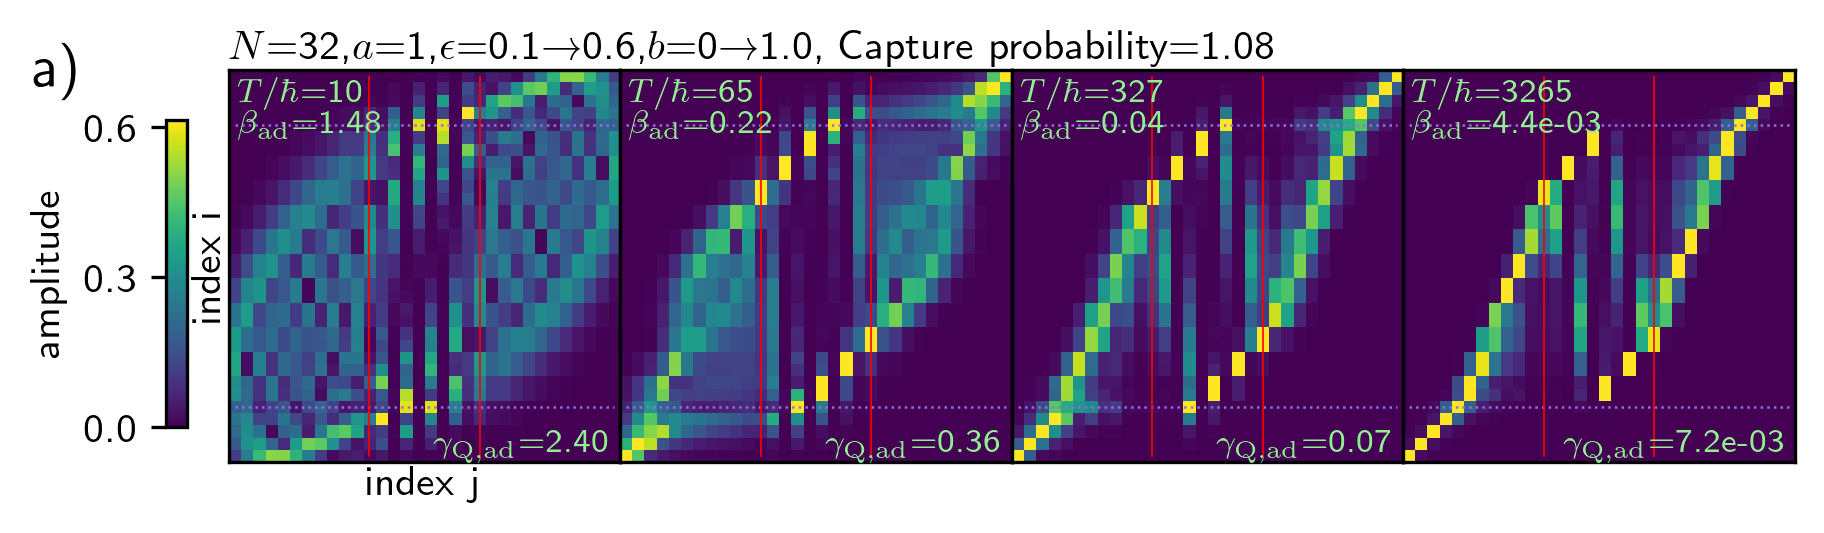

beta_ad = 1.48e+00, bdot = 5.15e-01
gamma_Q_add = 4.6e+00
beta_ad = 2.22e-01, bdot = 7.72e-02
gamma_Q_add = 6.9e-01
beta_ad = 4.44e-02, bdot = 1.54e-02
gamma_Q_add = 1.4e-01
beta_ad = 4.44e-03, bdot = 1.54e-03
gamma_Q_add = 1.4e-02


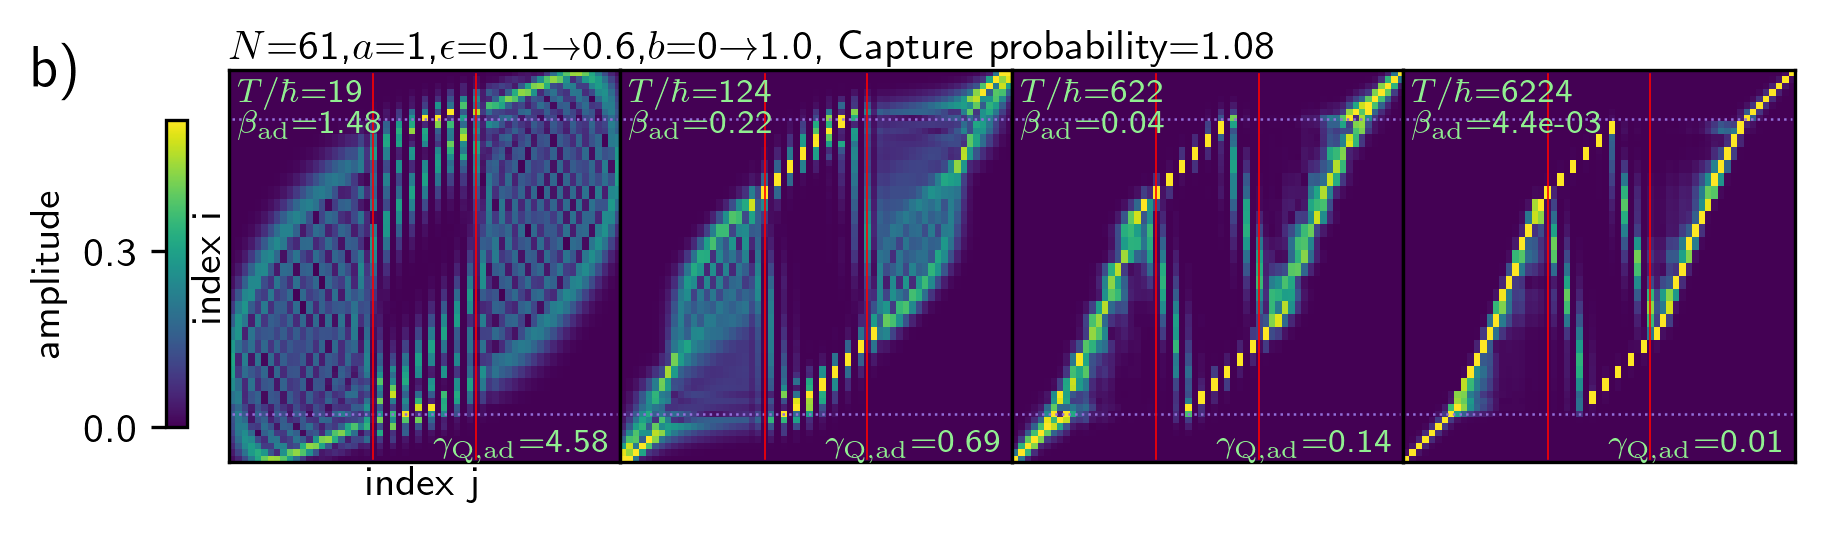

beta_ad = 1.48e+00, bdot = 5.15e-01
gamma_Q_add = 6.8e+00
beta_ad = 2.22e-01, bdot = 7.72e-02
gamma_Q_add = 1.0e+00
beta_ad = 4.44e-02, bdot = 1.54e-02
gamma_Q_add = 2.0e-01
beta_ad = 4.44e-03, bdot = 1.54e-03
gamma_Q_add = 2.0e-02


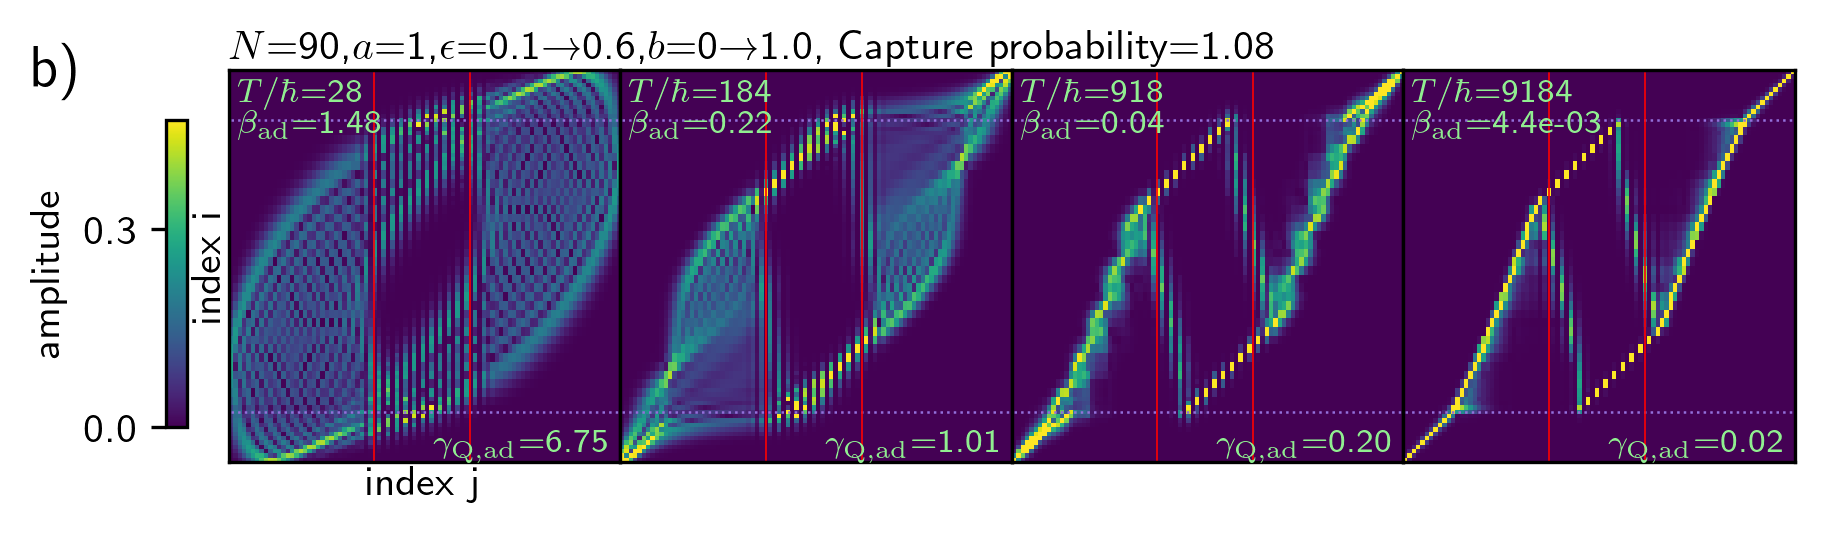

In [364]:
Tarr_fig_evar(zz_drift_c,tmatrix_series_c,Tarr_c,'a)','zz_drift_c.png') # show them 
Tarr_fig_evar(zz_drift_d,tmatrix_series_d,Tarr_d,'b)','zz_drift_d.png') # show them 
Tarr_fig_evar(zz_drift_e,tmatrix_series_e,Tarr_e,'b)','zz_drift_e.png') # show them 

In [354]:
# compute transition probability between various regions of libration and circulation 
def comp_trans_probs(dclass,Tmatrix):
    n = dclass.n
    pmatrix = np.square(np.copy(Tmatrix)) # element wise squares of each element in the transition matrix, giving probabilities 
    bottom,top = sep_energy(dclass)  # These are energies of the separatrix at different times 
    # indexes of sep initially
    ibottom_init = np.argmin(np.abs(dclass.w_list[0,:] - bottom[0])) 
    itop_init = np.argmin(np.abs(dclass.w_list[0,:] - top[0])) 
    # indices of sep finally 
    ibottom_final = np.argmin(np.abs(dclass.w_list[0,:] - bottom[-1]))  # indexes of sep at the end 
    itop_final = np.argmin(np.abs(dclass.w_list[0,:] - top[-1])) 
   
    # let's try this:
    itop_final = n-ibottom_final +1
    itop_init  = n-ibottom_init  +1

    #print(n,ibottom_init,itop_init,ibottom_final,itop_final)

    # lets make a 3x3  probability matrix 
    pstuff = np.zeros((3,3))   # 0 is lib left, 1 is circ, 2 is lib right
    # order is init,final

    # sum probabilities 
    # first index is initial, second is final 
    pstuff[0,0] = np.sum(pmatrix[0:ibottom_init,0:ibottom_final]) 
    pstuff[0,1] = np.sum(pmatrix[0:ibottom_init,ibottom_final:itop_final])
    pstuff[0,2] = np.sum(pmatrix[0:ibottom_init,itop_final:])
    pstuff[1,0] = np.sum(pmatrix[ibottom_init:itop_init,0:ibottom_final])
    pstuff[1,1] = np.sum(pmatrix[ibottom_init:itop_init,ibottom_final:itop_final])
    pstuff[1,2] = np.sum(pmatrix[ibottom_init:itop_init,itop_final:])
    pstuff[2,0] = np.sum(pmatrix[itop_init:,0:ibottom_final])
    pstuff[2,1] = np.sum(pmatrix[itop_init:,ibottom_final:itop_final])
    pstuff[2,2] = np.sum(pmatrix[itop_init:,itop_final:])
    # print(np.sum(pstuff)/n) I checked that this is 1! yay!
    return pstuff/n

# compute the 3x3 transition prob matrix for a series of transition matrices 
def comp_trans_probs_ser(dclass,Tmatrix_series):
    nser = Tmatrix_series.shape[0]
    pstuff_big = np.zeros((nser,3,3))
    pstuff_seq = np.zeros((nser*3,3))
    for k in range(nser):
        Tmatrix = np.squeeze(np.copy(Tmatrix_series[k,:,:]))
        pstuff = comp_trans_probs(dclass, Tmatrix)  # compute the 3x3 matrix 
        pstuff_big[k,:,:] = pstuff   #  load it into a larger matrix 
        pstuff_seq[k*3:k*3+3,:] = pstuff   # if you want it in a single image 2x2
    return pstuff_big, pstuff_seq

In [346]:
# make a figure of transition matrices, for the case of varying epsilon, b
# dclass is a drift class
# p_series is an array of probably transition matrices
# Tarr is the list of durations for drift
def Tarr_fig_probs(dclass,p_series,Tarr,ablabel,ofile):
    nser = len(Tarr)
    fig,axarr = plt.subplots(1,nser,figsize=(6.0,1.6),sharex=True,sharey=True,dpi=300)
    plt.subplots_adjust(hspace=0,wspace=0,top=0.95,right=0.99,left=0.14,bottom=0.05)
    zmax = np.max(np.squeeze(p_series[0,:,:]))
    eps_mid = (dclass.eps_0 + dclass.eps_final)/2
    #nn_b = dclass.d_b * dclass.nseries*dclass.n/np.pi + 1e-5
    om2 = dclass.a_0*eps_mid
    Delta_b = np.abs(dclass.b_final - dclass.b_0)
    #cmap = 'Purples'
    #cmap ='CMRmap'
    cmap = 'PuBuGn'
    for i in range(nser):
        Th = Tarr[i]; 
        label2 = r'$T/\hbar$={:.0f}'.format(Th)
        bdot = Delta_b/(Th*2*np.pi/dclass.n)
        beta_ad = bdot/om2
        #beta_ad = (10.0/nn_b) * (0.5/(eps_mid*dclass.a_0)) * (10/Tarr[i])
        if (beta_ad > 0.01):
            beta_lab = r'$\beta_{\mathrm a \mathrm d}$=' + '{:.2f}'.format(beta_ad)  # adiabatic limit
        else:
            beta_lab = r'$\beta_{\mathrm a \mathrm d}$=' + '{:.1e}'.format(beta_ad)
        #print(beta_lab)

        axarr[i].set_xticks([])
        axarr[i].set_yticks([])
        p_ma = np.squeeze(p_series[i,:,:])  # grab the 3x3 prob matrix 
        if (i==0):
            im0 = axarr[i].imshow(p_ma,origin='lower',cmap=cmap,vmin=0,vmax=zmax) # for colorbar
        else:
            im  = axarr[i].imshow(p_ma,origin='lower',cmap=cmap,vmin=0,vmax=zmax)
        
        gamma_Q_ad = (Delta_b/Th)* (dclass.n**2/(4*np.pi**3*eps_mid))
        print('gamma_Q_add = {:.1e}'.format(gamma_Q_ad)  ) 
        if (gamma_Q_ad > 0.01):
            gamma_lab = r'$\gamma_{\mathrm Q, \mathrm a \mathrm d}$=' + '{:.2f}'.format(gamma_Q_ad)  # adiabatic limit
        else:
            gamma_lab = r'$\gamma_{\mathrm Q, \mathrm a \mathrm d}$=' + '{:.1e}'.format(gamma_Q_ad) 

        axarr[i].text(0.02,0.92, label2, transform = axarr[i].transAxes,color='black',fontsize=8)
        axarr[i].text(0.02,0.84, beta_lab, transform = axarr[i].transAxes,color='green',fontsize=8)
        axarr[i].text(0.97,0.025, gamma_lab, transform = axarr[i].transAxes,color='green',fontsize=8,ha='right')
    
    # colorbar
    cax0=fig.add_axes([0.08,0.16,0.012,0.64])
    cbar0 = plt.colorbar(im0,cax=cax0,location='left',label='probability',format="%4.1f",ticks=[0.0,0.1,0.2,0.3])  
    #axarr[0].text(0.0,1.03, l1, transform = axarr[0].transAxes)
    
    axarr[0].text(-0.53,0.9,ablabel,fontsize=14,transform = axarr[0].transAxes)  # ab label

    axarr[0].text(0.1,-0.1,'j: lib',transform = axarr[0].transAxes,ha='center',fontsize=10)
    axarr[0].text(0.85,-0.1,'lib',transform = axarr[0].transAxes,ha='center',fontsize=10)
    axarr[0].text(0.5,-0.1,'circ',transform = axarr[0].transAxes,ha='center',fontsize=10)
    axarr[0].text(-0.07,0.05,'i: lib',transform = axarr[0].transAxes,ha='center',fontsize=10,rotation=90)
    axarr[0].text(-0.07,0.45,'circ',transform = axarr[0].transAxes,ha='center',fontsize=10,rotation=90)
    axarr[0].text(-0.07,0.8,'lib',transform = axarr[0].transAxes,ha='center',fontsize=10,rotation=90)

    l1 = r'$N$={:d},$a$={:.0f},'.format(dclass.n,dclass.a_0)
    l2 = r'$\epsilon$={:.1f}'.format(dclass.eps_0) + '\u2192' + '{:.1f},'.format(dclass.eps_final)   
    lb = r'$b$={:.0f}'.format(dclass.b_0) + '\u2192' + r'{:.1f}'.format(dclass.b_final) 
    

    # compute probability of capture
    Delta_eps = np.abs(dclass.eps_0 - dclass.eps_final)
    Delta_b = np.abs(dclass.b_0 - dclass.b_final)
    eps_mid = np.abs(dclass.eps_0 + dclass.eps_final)/2
    P_c = (Delta_eps/Delta_b) * 4/(np.pi*np.sqrt(eps_mid))  
    pclabel = r', Capture probability={:.2f}'.format(P_c)
    axarr[0].text(0.0,1.03, l1+l2+lb+pclabel, transform = axarr[0].transAxes) 
    
    #l1 = l1+l2+lb+pclabel

    if (len(ofile)>3):
        plt.savefig(ofile)
    plt.show()




gamma_Q_add = 6.0e+00
gamma_Q_add = 6.0e-01
gamma_Q_add = 1.2e-01
gamma_Q_add = 1.2e-02


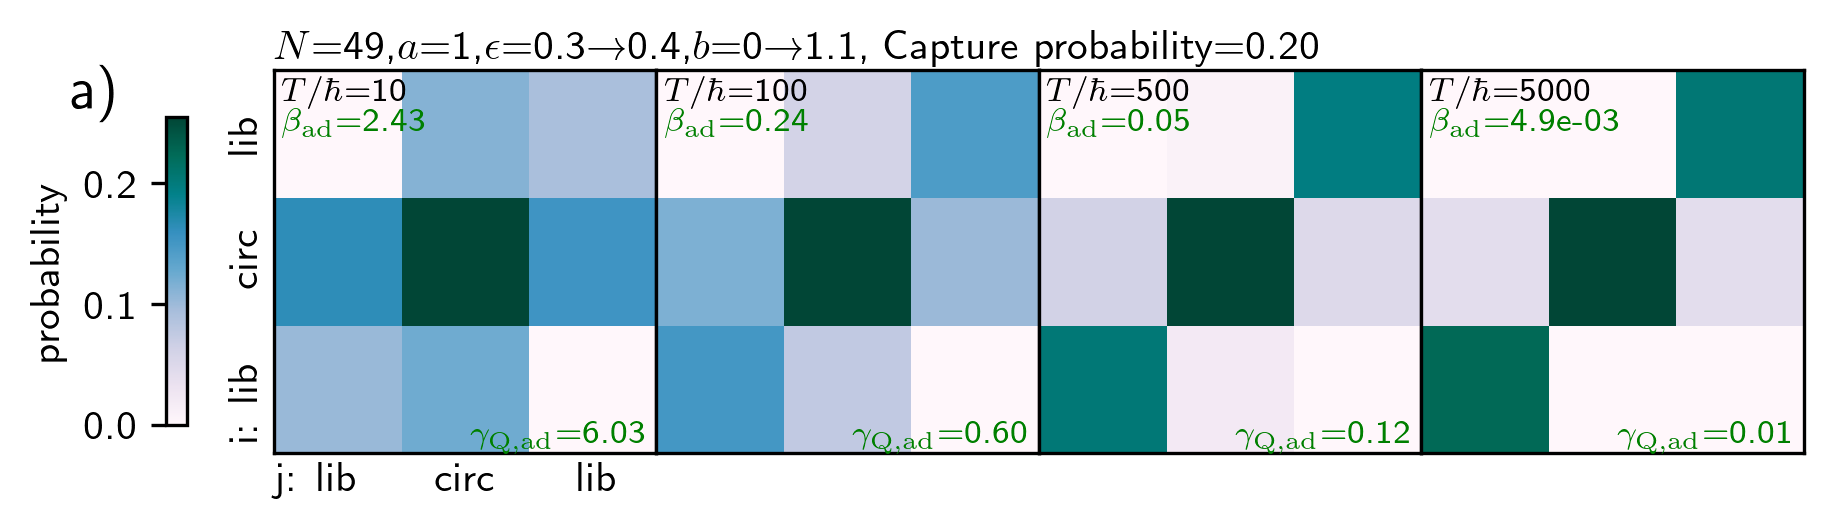

gamma_Q_add = 3.7e+00
gamma_Q_add = 5.5e-01
gamma_Q_add = 1.1e-01
gamma_Q_add = 1.1e-02


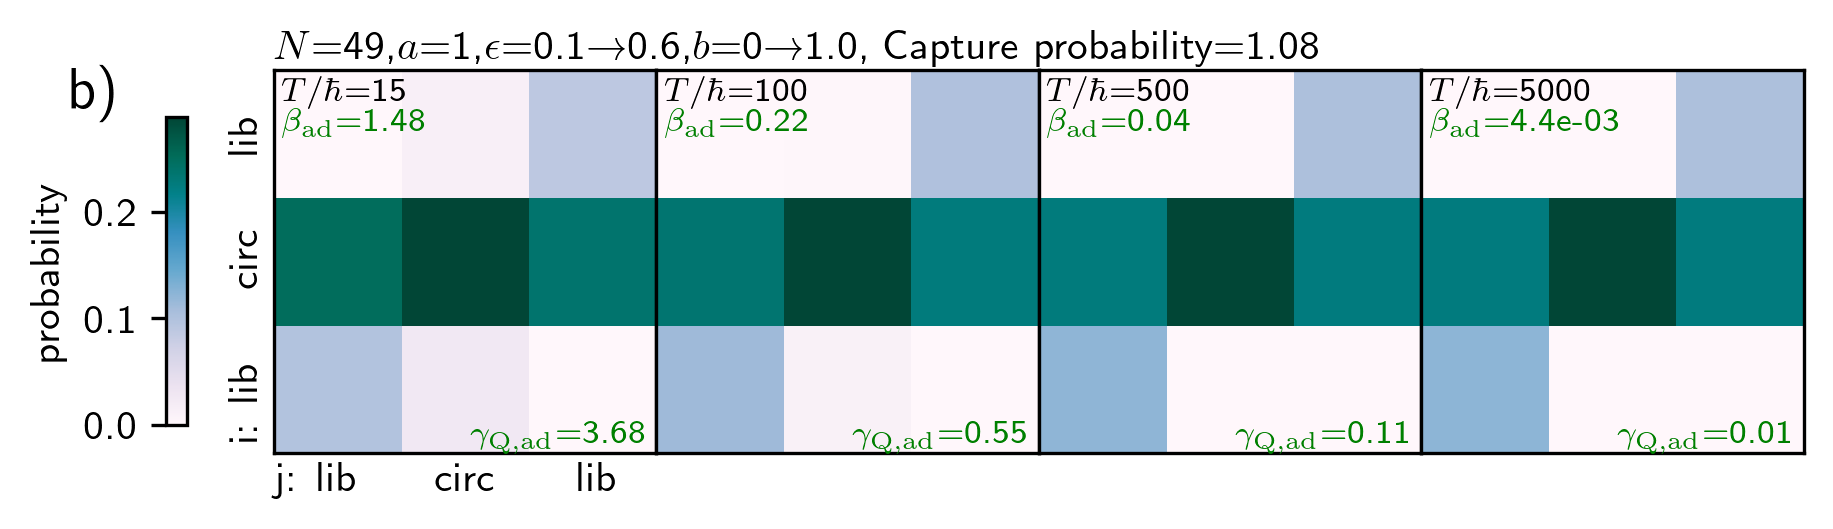

gamma_Q_add = 2.4e+00
gamma_Q_add = 3.6e-01
gamma_Q_add = 7.2e-02
gamma_Q_add = 7.2e-03


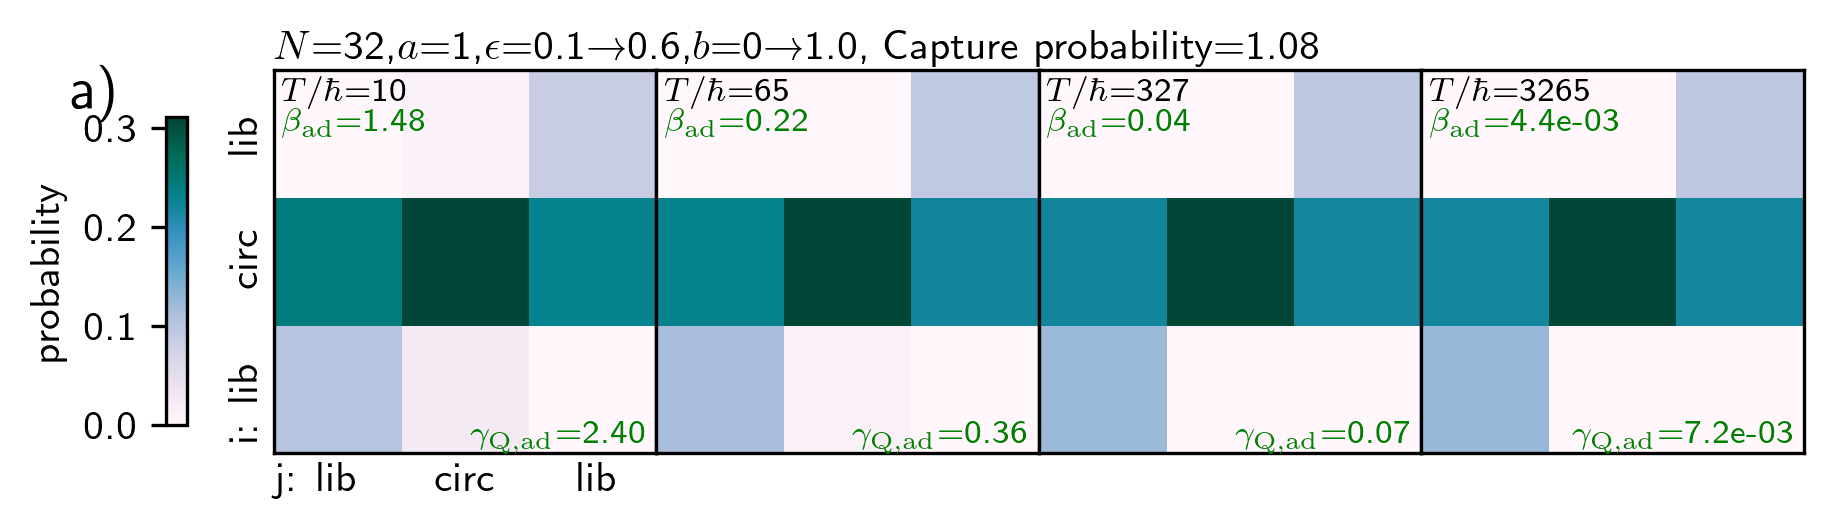

gamma_Q_add = 4.6e+00
gamma_Q_add = 6.9e-01
gamma_Q_add = 1.4e-01
gamma_Q_add = 1.4e-02


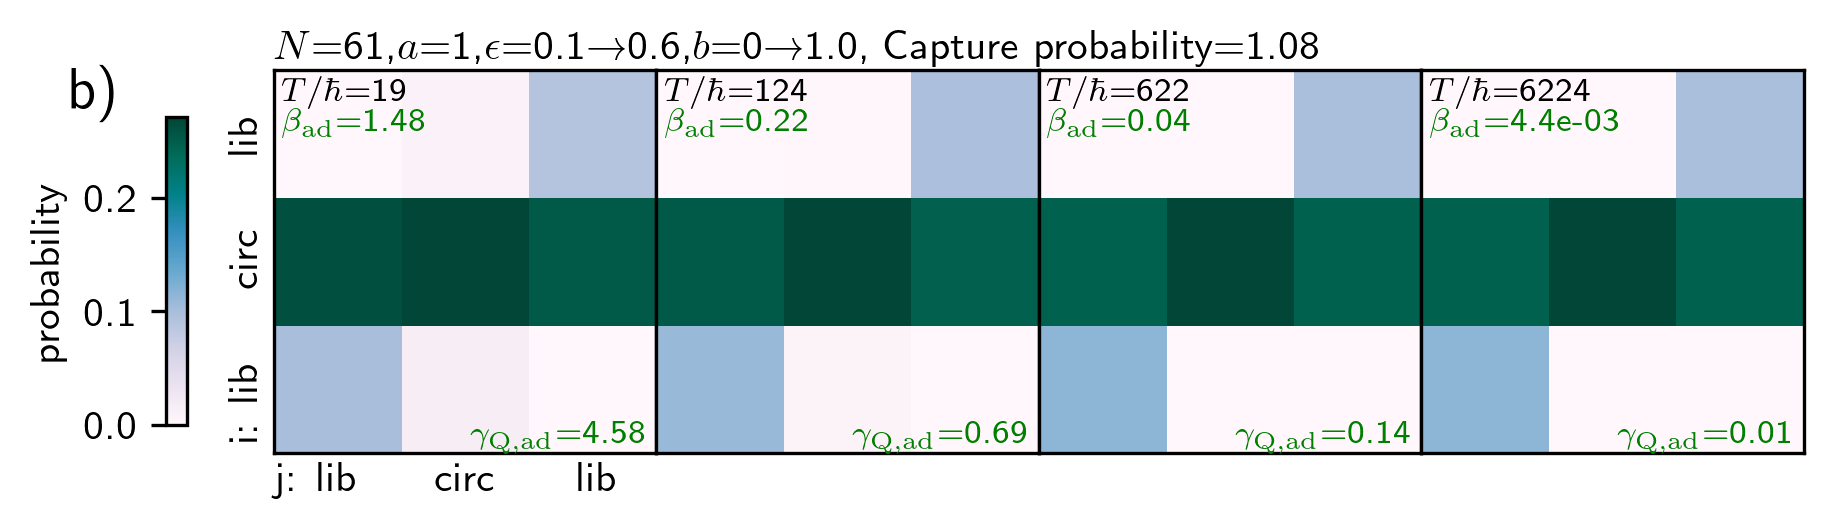

gamma_Q_add = 6.8e+00
gamma_Q_add = 1.0e+00
gamma_Q_add = 2.0e-01
gamma_Q_add = 2.0e-02


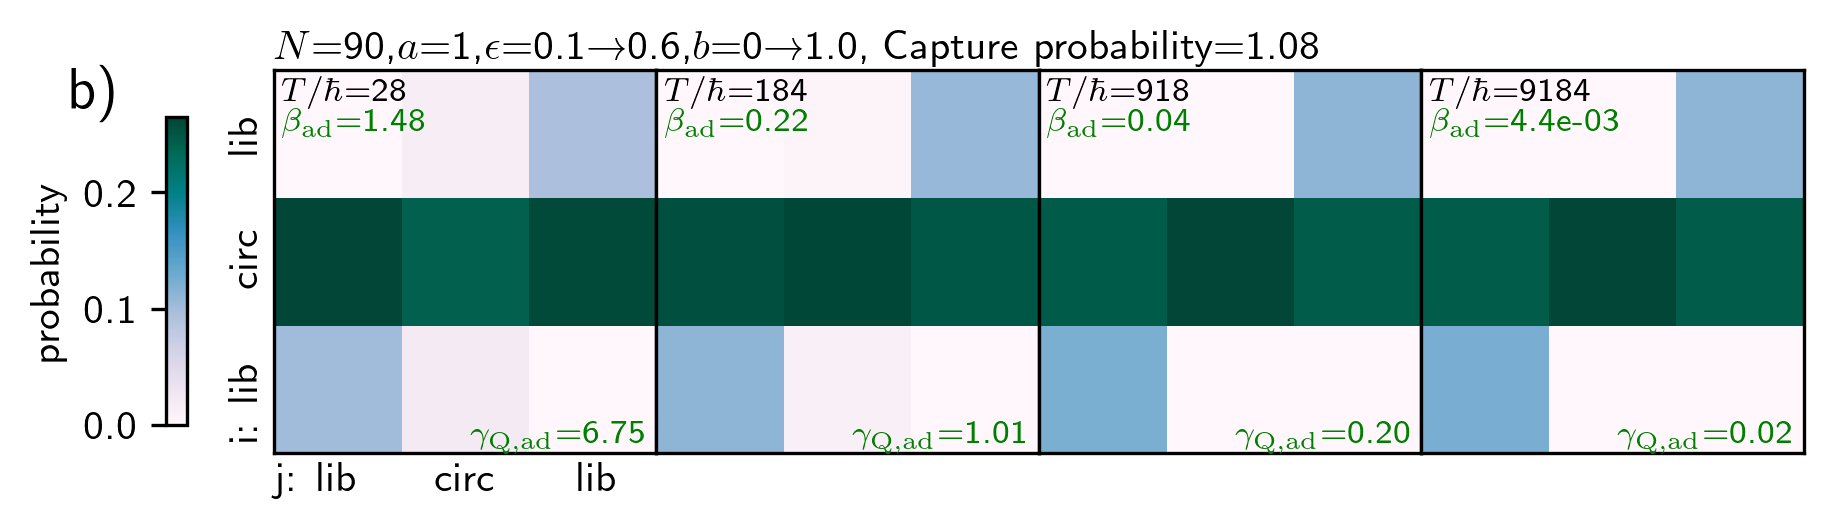

In [366]:

pstuff_big_a,pstuff_seq_a = comp_trans_probs_ser(zz_drift_a,tmatrix_series_a)
pstuff_big_b,pstuff_seq_b = comp_trans_probs_ser(zz_drift_b,tmatrix_series_b)
pstuff_big_c,pstuff_seq_c = comp_trans_probs_ser(zz_drift_c,tmatrix_series_c)
pstuff_big_d,pstuff_seq_d = comp_trans_probs_ser(zz_drift_d,tmatrix_series_d)
pstuff_big_e,pstuff_seq_e = comp_trans_probs_ser(zz_drift_e,tmatrix_series_e)


Tarr_fig_probs(zz_drift_a,pstuff_big_a,Tarr_a,'a)','zz_probs_a.png')
Tarr_fig_probs(zz_drift_b,pstuff_big_b,Tarr_b,'b)','zz_probs_b.png')
Tarr_fig_probs(zz_drift_c,pstuff_big_c,Tarr_c,'a)','zz_probs_c.png')
Tarr_fig_probs(zz_drift_d,pstuff_big_d,Tarr_d,'b)','zz_probs_d.png')
Tarr_fig_probs(zz_drift_e,pstuff_big_e,Tarr_e,'b)','zz_probs_e.png')